# Find scaffolds and MMPs to guide Reinvent generation.

The purpose of this notebook is to process Chembl data for a specific target (EP4) to develop a list of compounds to guide generation with Reinvent. 

In [1]:
import pandas as pd
import os
from IPython import display

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Read in Chembl data for EP4.

In [2]:
ep4_chembl = pd.read_csv('ep4_chembl.csv', delimiter=';')

In [3]:
ep4_chembl.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL172250,NaN,NaN,478.57,0,4.72,16b,O=C(O)CCCCCC[C@@H]1[C@@H](CCC(O)CSc2cccc(C(F)(...,IC50,'>',...,SINGLE PROTEIN,CHEMBL1132967,1,Scientific Literature,J Med Chem,2000,CHEMBL3308072,NaN,NaN,NaN
1,CHEMBL2385898,NaN,NaN,398.46,0,4.39,29,Cc1ccc2c(c1)c1c(n2CC(=O)O)CCN(C(=O)c2cccc3cccc...,IC50,'>',...,SINGLE PROTEIN,CHEMBL2385063,1,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN
2,CHEMBL2386080,NaN,NaN,418.88,0,4.73,27,O=C(O)Cn1c2c(c3cc(Cl)ccc31)CN(C(=O)c1cccc3cccc...,IC50,'>',...,SINGLE PROTEIN,CHEMBL2385063,1,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN
3,CHEMBL2386077,NaN,NaN,386.81,0,3.72,24,O=C(O)Cn1c2c(c3cc(F)ccc31)CN(C(=O)c1cccc(Cl)c1...,IC50,'>',...,SINGLE PROTEIN,CHEMBL2385063,1,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN
4,CHEMBL2386075,NaN,NaN,358.39,0,3.13,22,O=C(O)Cn1c2c(c3cc(F)ccc31)CN(C(=O)c1cccs1)CC2,IC50,'>',...,SINGLE PROTEIN,CHEMBL2385063,1,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN


# Matched molecular series.

Purpose: find distinct scaffolds that lead to active compounds.

In [4]:
import pandas as pd
from rdkit import Chem
from utils.scaffold_finder import FragmentMol
from tqdm.auto import tqdm
import useful_rdkit_utils as uru
from itertools import combinations
import mols2grid
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import ReactionToImage
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np

from IPython.display import HTML
import matplotlib.pyplot as plt

from utils.MMP import sort_fragments, remove_map_nums, rxn_to_base64_image, strippplot_base64_image_pic50, find_examples_pic50

In [5]:
tqdm.pandas()

Convert ic50 to pIC50.

In [6]:
ep4_chembl['pic50'] = ep4_chembl['Standard Value'].apply(lambda x: -np.log10(1e-6*x))

pIC50 range of compounds - most are poor ligands in this case, but let's go with them anyway.

<Axes: xlabel='pic50', ylabel='Count'>

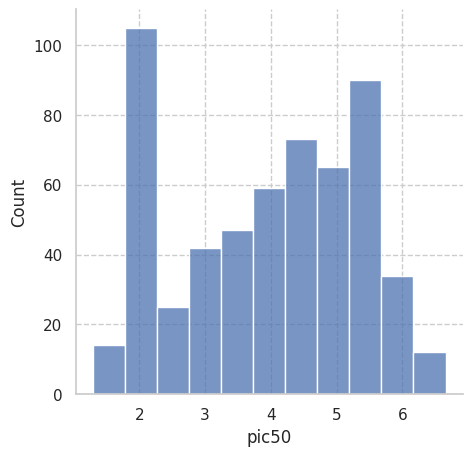

In [7]:
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'grid.linestyle': '--', 'figure.figsize':(5,5)}
sns.set_theme(style="whitegrid", rc=custom_params)

sns.histplot(ep4_chembl, x='pic50')

Keep only reasonably potent compounds.

In [8]:
ep4_chembl_potent = ep4_chembl[(ep4_chembl['pic50'] > 5)]

Remove duplicates and stereochem for Reinvent, fragment into cores and R-groups.

In [10]:
ep4_chembl_potent = ep4_chembl_potent.drop_duplicates(subset=['Smiles'])

In [ ]:
ep4_chembl_potent['mol'] = ep4_chembl_potent.Smiles.apply(Chem.MolFromSmiles)
ep4_chembl_potent.apply(lambda x: Chem.RemoveStereochemistry(x.mol), axis=1)
ep4_chembl_potent['smiles_no_stereo'] = ep4_chembl_potent.mol.apply(Chem.MolToSmiles)
ep4_chembl_potent.mol = ep4_chembl_potent.mol.apply(uru.get_largest_fragment)
ep4_chembl_potent = ep4_chembl_potent.reset_index(drop=True)

/tmp/ipykernel_4878/957393681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ep4_chembl_potent['mol'] = ep4_chembl_potent.Smiles.apply(Chem.MolFromSmiles)
/tmp/ipykernel_4878/957393681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ep4_chembl_potent['smiles_no_stereo'] = ep4_chembl_potent.mol.apply(Chem.MolToSmiles)
/tmp/ipykernel_4878/957393681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [226]:
ep4_chembl_potent = ep4_chembl_potent[['Molecule ChEMBL ID', 'Smiles', 'pic50', 'mol', 'smiles_no_stereo']]

Compare cores by fragmenting them.

In [22]:
row_list = []

for DOCUMENT, SMILES, pic50, mol, smiles_no_stereo in tqdm(ep4_chembl_potent.values):
    frag_list = FragmentMol(mol,maxCuts=1)
    for _,frag_mol in frag_list:
        pair_list = sort_fragments(frag_mol)
        tmp_list = [SMILES]+[Chem.MolToSmiles(x) for x in pair_list]+[DOCUMENT, pic50]
        row_list.append(tmp_list)
row_df = pd.DataFrame(row_list,columns=["Smiles","Core","R_group","Name","pic50"])
row_df.head(4)

  0%|          | 0/134 [00:00<?, ?it/s]

,Smiles,Core,R_group,Name,pic50
0,CCOc1c2c(c(OCC)c3ccccc13)C(=O)N(c1ccc(CC3(NC(=...,*COc1c2c(c(OCC)c3ccccc13)C(=O)N(c1ccc(CC3(NC(=...,*C,CHEMBL1669006,5.481486
1,CCOc1c2c(c(OCC)c3ccccc13)C(=O)N(c1ccc(CC3(NC(=...,*Oc1c2c(c(OCC)c3ccccc13)C(=O)N(c1ccc(CC3(NC(=O...,*CC,CHEMBL1669006,5.481486
2,CCOc1c2c(c(OCC)c3ccccc13)C(=O)N(c1ccc(CC3(NC(=...,*c1c2c(c(OCC)c3ccccc13)C(=O)N(c1ccc(CC3(NC(=O)...,*OCC,CHEMBL1669006,5.481486
3,CCOc1c2c(c(OCC)c3ccccc13)C(=O)N(c1ccc(CC3(NC(=...,*c1c2c(c(OCC)c3ccccc13)CN(c1ccc(CC3(NC(=O)NS(=...,*OCC,CHEMBL1669006,5.481486


What scaffolds are we seeing?

In [23]:
scaffold_df = row_df.Core.value_counts().to_frame().reset_index()
scaffold_df.columns = ["Smiles","Count"]
scaffold_df['mol'] = scaffold_df.Smiles.apply(Chem.MolFromSmiles)
_ = scaffold_df.mol.apply(AllChem.Compute2DCoords)

In [ ]:
# mols2grid is too heavy!

# mols2grid.display(scaffold_df,subset=["img","Count"],mol_col="mol",
#                   use_coords=True,prerender=True)

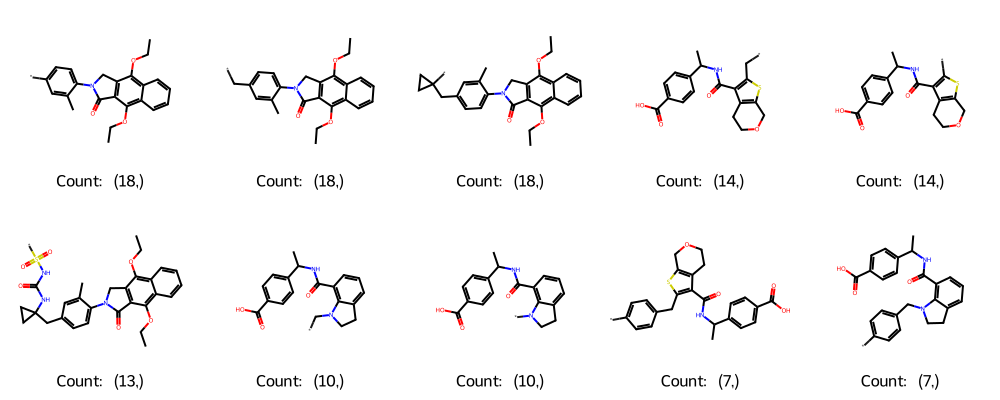

In [ ]:
from rdkit.Chem import Draw
from rdkit import Chem

Draw.MolsToGridImage(
    mols=[Chem.MolFromSmiles(s) for s in scaffold_df.Smiles],
    legends=[
        f"Count:  {i}" for i in zip(
            scaffold_df['Count'],
            # scaffold_df['Cluster_PC1_PC2']
        )
    ],
    molsPerRow=5,
    maxMols=10,
)

# Data-driven clustering.

Cores are quite diverse and some are very large, so fragmentation doesn't help to distinguish them. We need to cluster. 

* PCA with RdKit descriptors.
* Cluster within PC1 vs PC2 

In [86]:
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

import progressbar
from math import pi

%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)

In [87]:
from utils.rdkit_descriptors import rdkit_descriptor

descriptor_list = [
                    "mw", 
                    "tpsa", 
                    "logp", 
                    "hba", 
                    "hbd", 
                    "num_het_atoms", 
                    "num_rot_bonds", 
                    "num_heavy_atoms", 
                    "num_aliphatic_carbocycles", 
                    "num_aliphatic_carbocycles_mw", 
                    "num_aliphatic_heterocycles", 
                    "num_aliphatic_heterocycles_mw", 
                    "num_aliphatic_rings", 
                    "num_aliphatic_rings_mw", 
                    "num_aromatic_carbocycles", 
                    "num_aromatic_heterocycles",
                    "num_aromatic_rings", 
                    "ring_count", 
                    "fraction_csp3", 
                    # "radius_gyration", 
                    "charge",
                    "LE"
                    ]

In [88]:
for descriptor in descriptor_list:
    if descriptor != 'LE':
        ep4_chembl_potent[f'{descriptor}'] = ep4_chembl_potent.apply(lambda x: rdkit_descriptor(x.Smiles, descriptor), axis=1)

In [89]:
descriptors = ep4_chembl_potent[[
    'pic50',
    'tpsa',
    'mw', 
    'logp',
    'num_rot_bonds',
    'hbd',
    ]].values 
descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = ep4_chembl_potent.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

,PC1,PC2,PC3,PC4,PC5,PC6
0,3.316827,1.084800,-0.403152,0.470233,0.009396,0.064996
1,2.812404,1.192019,-0.327703,0.196120,-0.101685,-0.079469
2,-0.265908,-0.704544,0.378080,1.174989,0.203748,-0.165036
3,-0.396029,-0.511172,0.504657,1.132415,0.028477,0.104869
4,-0.263714,-0.872996,-0.020843,0.549974,0.277005,-0.008769


In [90]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))

[0.37584753 0.2717988  0.16301698 0.13253223 0.04617832 0.01062613]
1.0


Scree plot to tell us how many components to keep. We want to keep enough to explain > 90% of the variance.

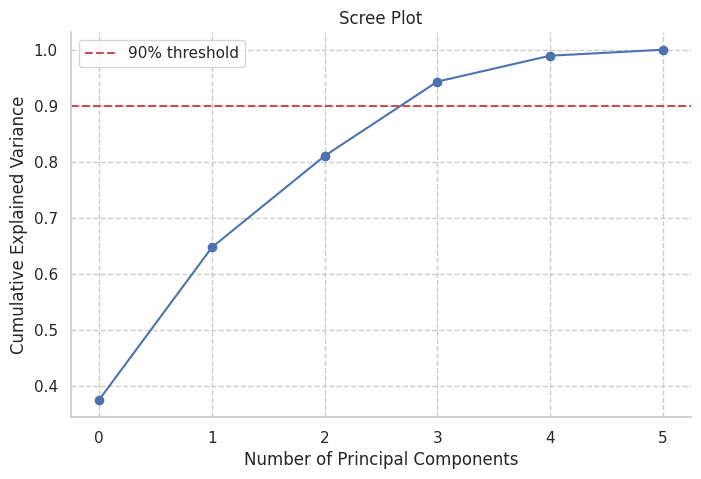

In [91]:
import matplotlib.pyplot as plt
import numpy as np

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.legend()
plt.show()

In [92]:
# In this case, we explain over 90% of the variance with PCs.
# The normalization is to plot PCA values in 0-1 sacle and include the vectors (features to the plot)

for PC in range(1, 4):
    scale = 1.0/(max(descriptors_pca[f'PC{PC}']) - min(descriptors_pca[f'PC{PC}']))

    # And we add the new values to our PCA table
    descriptors_pca[f'PC{PC}_normalized']=[i*scale for i in descriptors_pca[f'PC{PC}']]

In [93]:
descriptors_pca.head(5) # The PCA table now has the normalized PC1 and PC2

,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized,PC3_normalized
0,3.316827,1.084800,-0.403152,0.470233,0.009396,0.064996,0.458847,0.174058,-0.077433
1,2.812404,1.192019,-0.327703,0.196120,-0.101685,-0.079469,0.389066,0.191262,-0.062942
2,-0.265908,-0.704544,0.378080,1.174989,0.203748,-0.165036,-0.036785,-0.113045,0.072617
3,-0.396029,-0.511172,0.504657,1.132415,0.028477,0.104869,-0.054786,-0.082019,0.096929
4,-0.263714,-0.872996,-0.020843,0.549974,0.277005,-0.008769,-0.036482,-0.140074,-0.004003


Silhouette plots to determine how many clusters we need.

For n_clusters = 2 The average silhouette_score is : 0.4325490426133012
For n_clusters = 3 The average silhouette_score is : 0.4298650530613452
For n_clusters = 4 The average silhouette_score is : 0.47063125191863714
For n_clusters = 5 The average silhouette_score is : 0.48083078571915955
For n_clusters = 6 The average silhouette_score is : 0.36793262009762057
For n_clusters = 7 The average silhouette_score is : 0.3834754423786979
For n_clusters = 8 The average silhouette_score is : 0.32577245875606603
For n_clusters = 9 The average silhouette_score is : 0.35654928590443674
For n_clusters = 10 The average silhouette_score is : 0.3610754833857392
For n_clusters = 11 The average silhouette_score is : 0.37220039183158743
For n_clusters = 12 The average silhouette_score is : 0.34218185924715494
For n_clusters = 13 The average silhouette_score is : 0.34194491135906147
For n_clusters = 14 The average silhouette_score is : 0.3532618773058513
For n_clusters = 15 The average silhouette_score is

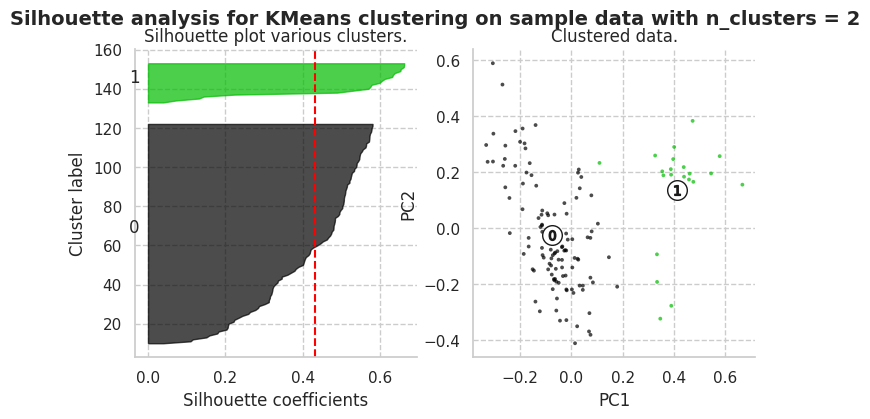

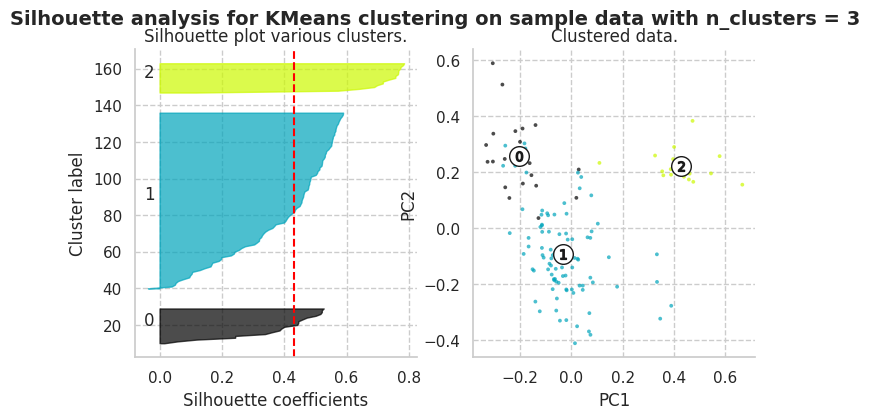

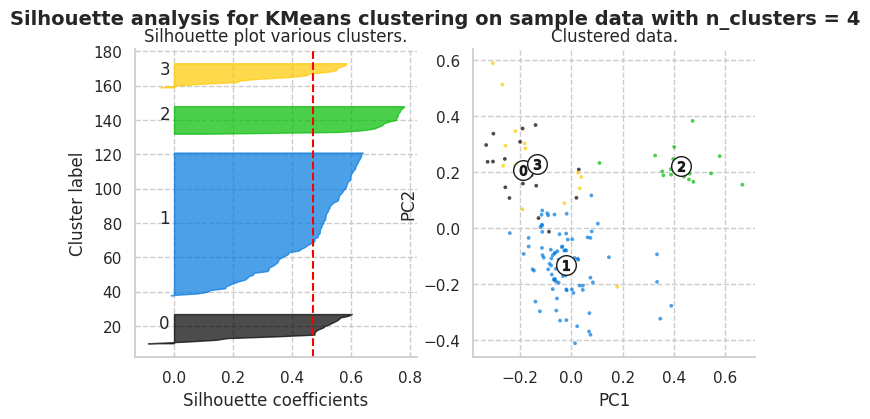

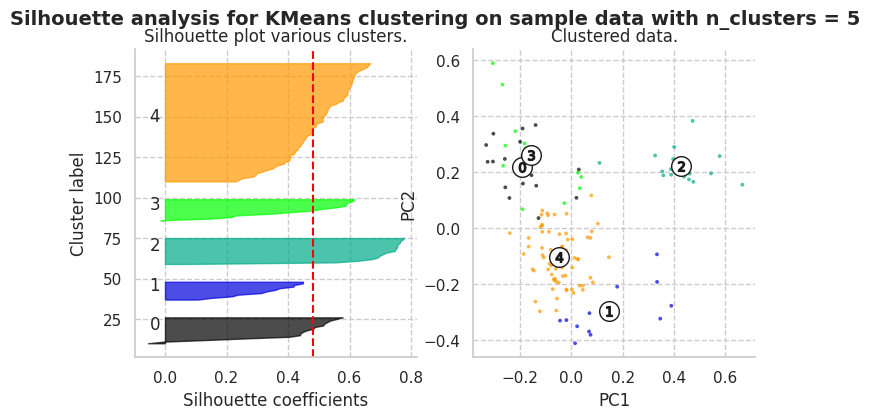

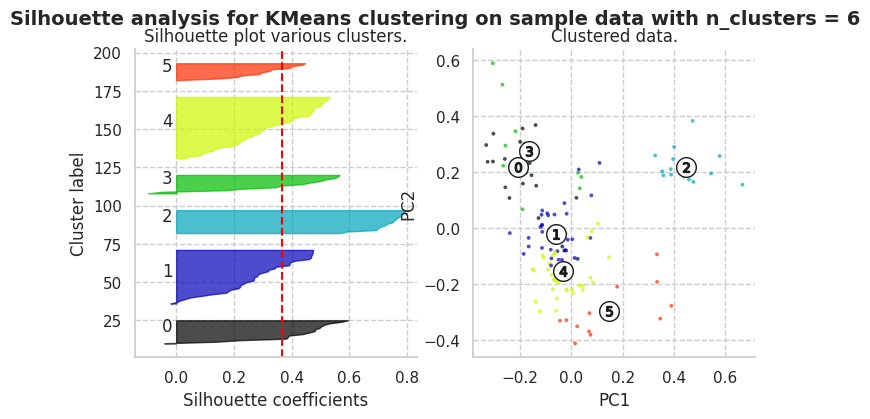

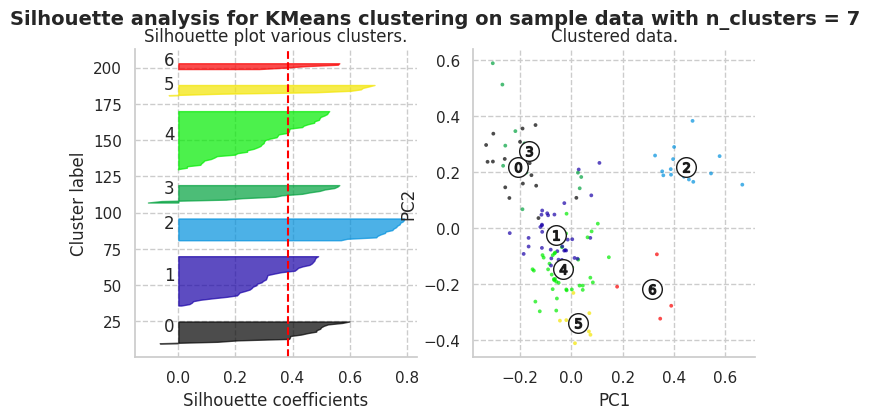

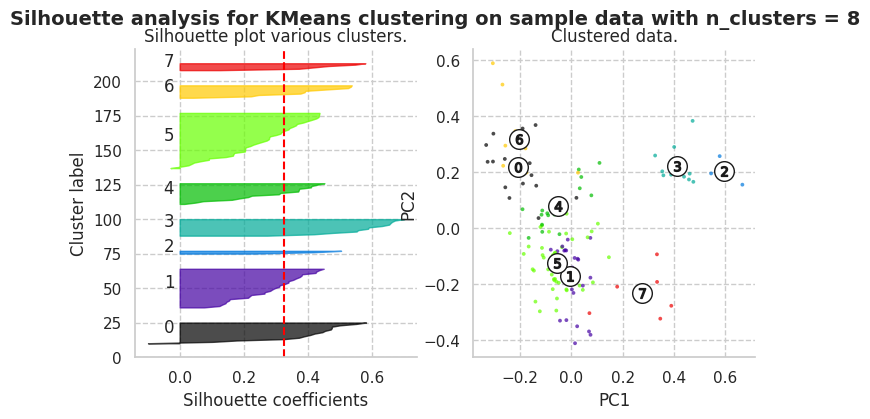

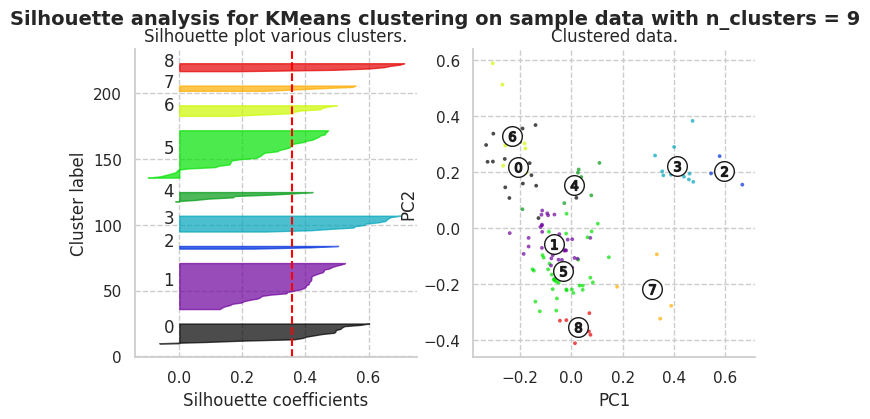

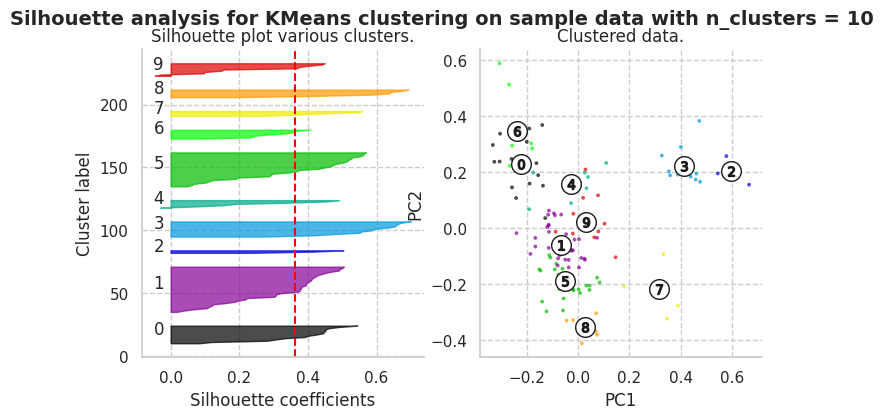

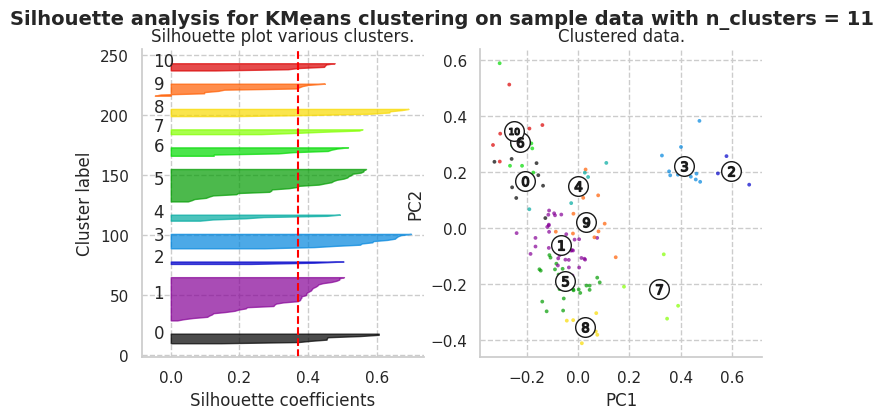

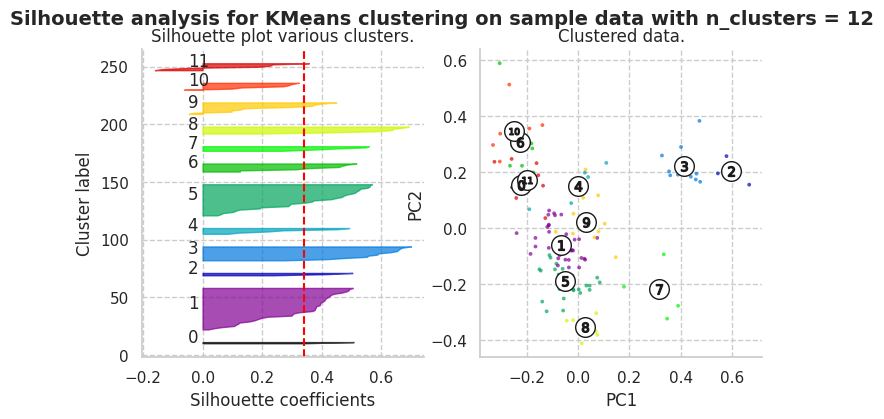

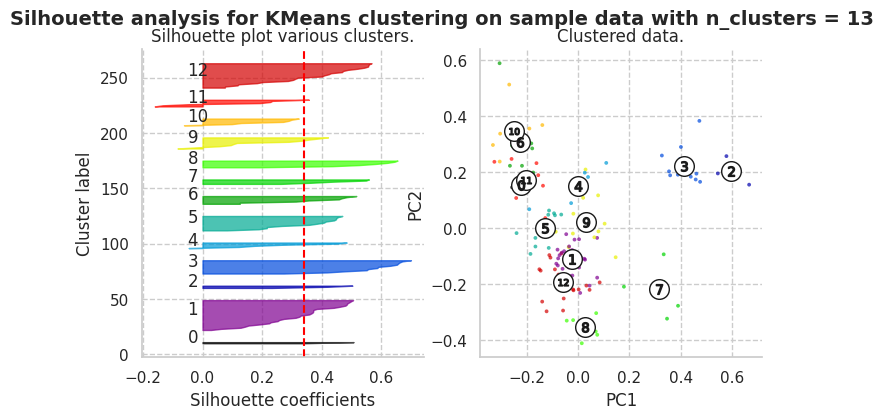

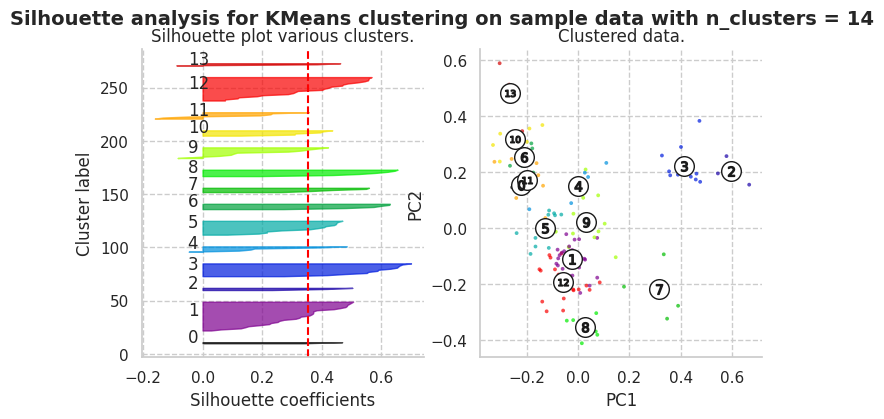

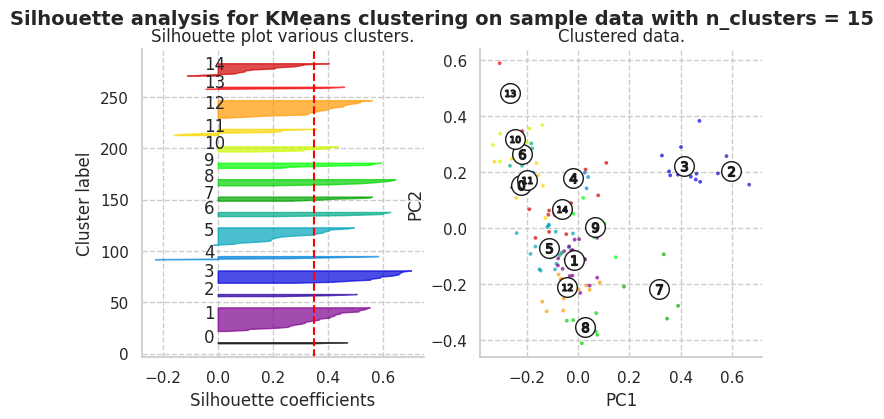

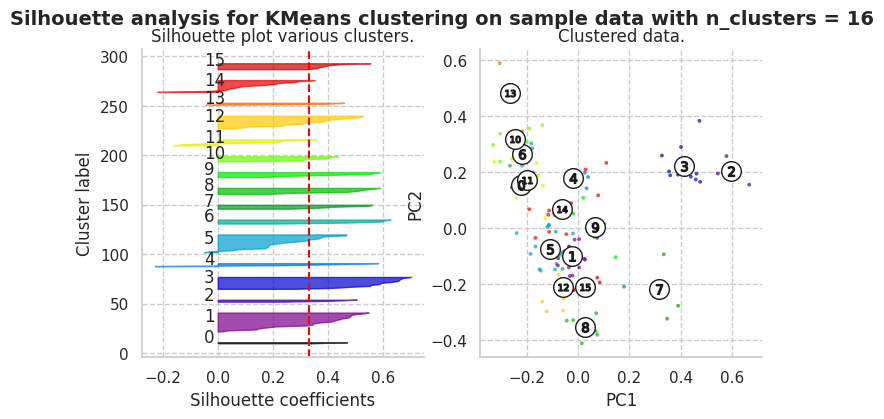

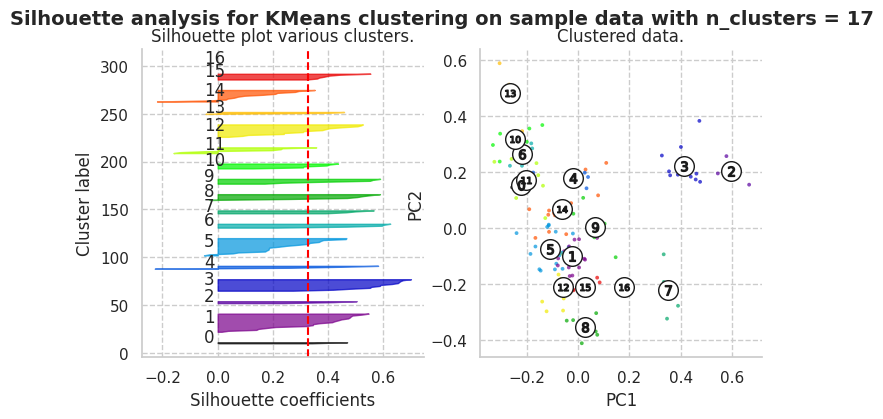

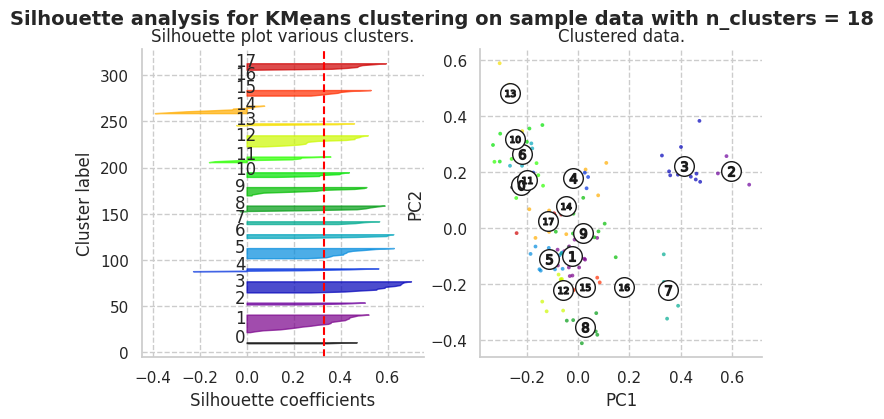

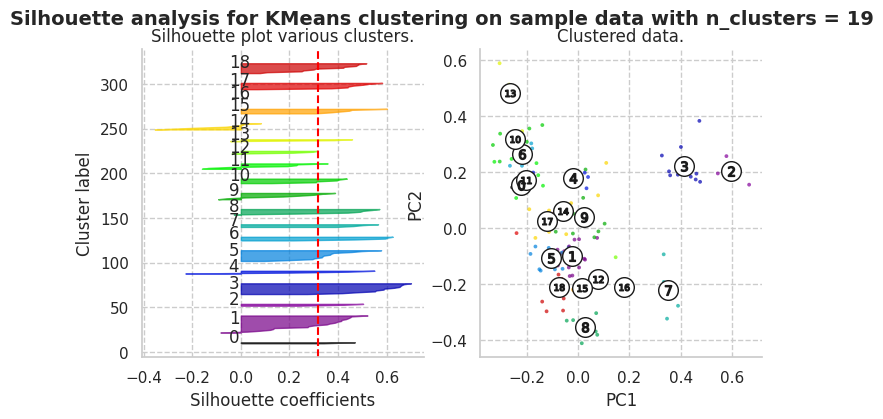

In [94]:
for n_clusters in range(2, 20):
    fig, (ax1,ax2)= plt.subplots(1, 2)
    fig.set_size_inches(8, 4)

    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized', 'PC3_normalized']])
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized','PC2_normalized', 'PC3_normalized']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized','PC2_normalized', 'PC3_normalized']], cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot various clusters.")
    ax1.set_xlabel("Silhouette coefficients")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')


    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


plt.show()

In [95]:
# Optimal number of clusters **5** (highest silouette score). 
# Do kmeans clustering next.

kmeans = KMeans(n_clusters=5, random_state=10) # We define the best number of clusters
clusters = kmeans.fit(descriptors_pca[['PC1_normalized','PC2_normalized']]) #PC1 vs PC2 (normalized values)
descriptors_pca['Cluster_PC1_PC2'] = pd.Series(clusters.labels_, index=ep4_chembl_potent.index)
descriptors_pca = pd.concat([descriptors_pca, ep4_chembl_potent[['Molecule ChEMBL ID', 'smiles_no_stereo', 'pic50']]], axis = 1) # add document numbers back to see cluster membership

How many molecules in each cluster?

<Axes: xlabel='Cluster_PC1_PC2', ylabel='count'>

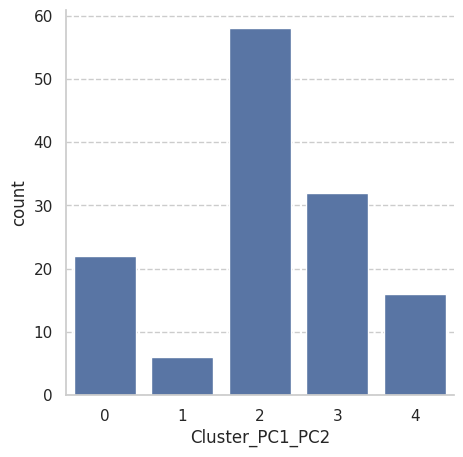

In [96]:
sns.countplot(descriptors_pca, x="Cluster_PC1_PC2")

Quick look at the largest cluster.

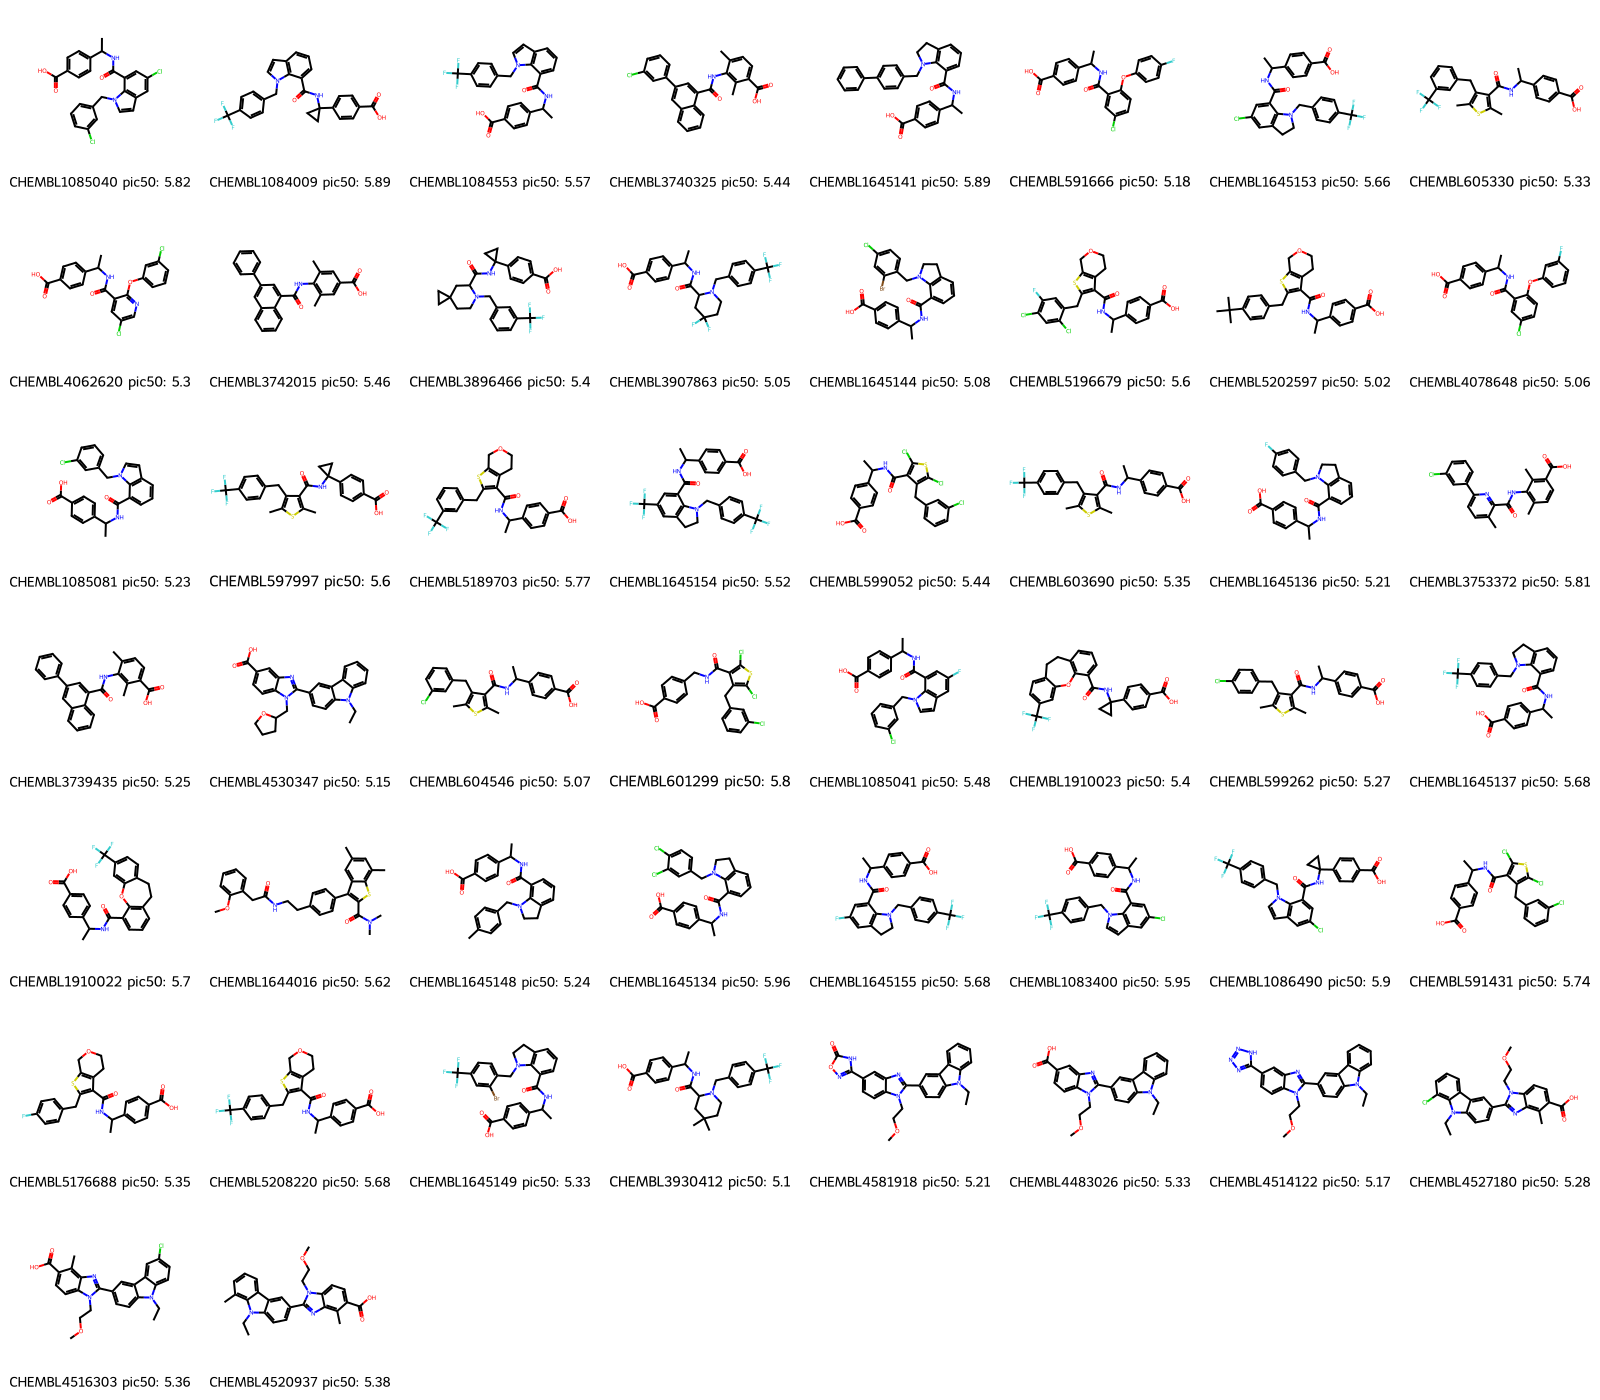

In [103]:
cluster_id = 2

descriptors_pca_cluster = descriptors_pca[descriptors_pca['Cluster_PC1_PC2'] == cluster_id]

Draw.MolsToGridImage(
    mols=[Chem.MolFromSmiles(s) for s in descriptors_pca_cluster.smiles_no_stereo],
    legends=[
        f"{i} pic50: {j}" for i, j in zip(
            descriptors_pca_cluster['Molecule ChEMBL ID'],
            descriptors_pca_cluster['pic50'].round(2)
        )
    ],
    molsPerRow=8,
    maxMols=50,
)

Take a random sample of 50% of compounds from each cluster.

In [61]:
sampled_df = descriptors_pca.groupby('Cluster_PC1_PC2', group_keys=False).sample(frac=0.5, random_state=1)

Output to guidance file for Reinvent (may still need to manually alter the SMILES if they have salts or halogens in them).

In [62]:
sampled_df['smiles_no_stereo'].to_csv('ep4_chembl_ligs.smi', index=False, header=False)

# Find fragment for Libinvent.

From the biggest cluster, we can see that the amido benzoic acid appears to be in the most potent compounds. Maybe replacing the substituent on the indole will give us greater potency. 

In [105]:
descriptors_pca_cluster.smiles_no_stereo.iloc[0]

'CC(NC(=O)c1cc(Cl)cc2ccn(Cc3cccc(Cl)c3)c12)c1ccc(C(=O)O)cc1'